In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2DTranspose, Conv2D, Input, BatchNormalization, Activation, concatenate
)
import os
import numpy as np 
from tensorflow.keras import layers
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt

C:\Users\Tanma\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = ''
image_path = os.path.join(path, 'data/images/')
mask_path = os.path.join(path, 'data/panoptic/')
image_list_orig = os.listdir(image_path)
mask_list_orig = os.listdir(mask_path)
image_list = [os.path.join(image_path, i) for i in image_list_orig if i.endswith('.jpg')][:2000]
mask_list = [os.path.join(mask_path, i) for i in mask_list_orig if i.endswith('.png')][:2000]

test_image_path = os.path.join(path, 'val_cityscapes/img/')
test_image_list_orig = os.listdir(test_image_path)
test_image_list = [test_image_path+i for i in test_image_list_orig if i.endswith('.png')]


In [3]:
def process_test_path(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (96, 128))
    return img

# Preprocess testing data
test_image_filenames = tf.constant(test_image_list)

# Convert to TensorFlow Dataset
test_image_ds = tf.data.Dataset.from_tensor_slices(test_image_filenames)

# Apply preprocessing function to the dataset
test_image_ds = test_image_ds.map(process_test_path)


C:\Users\Tanma\AppData\Local\Temp\ipykernel_4732\1645610153.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\Tanma\AppData\Local\Temp\ipykernel_4732\1645610153.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

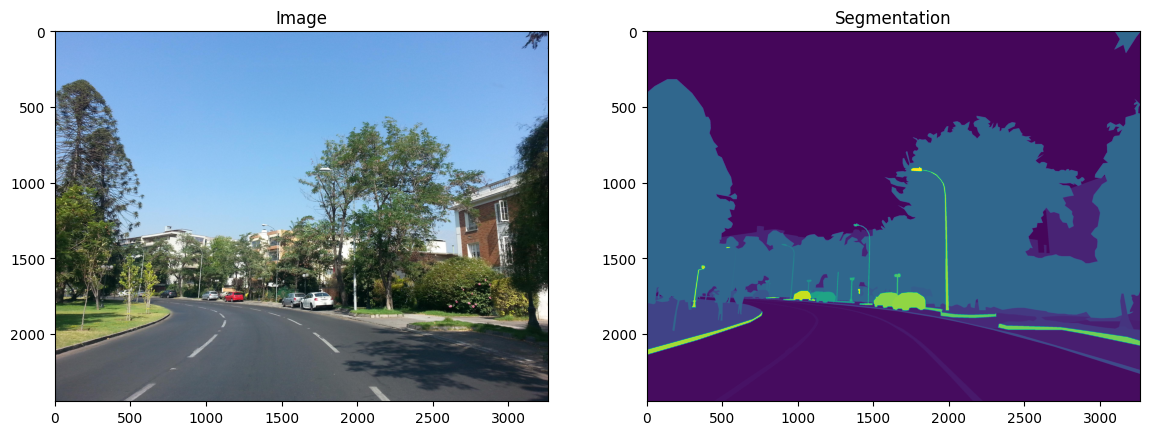

In [4]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--NSVcUgfVhFd6uzkqHOOg.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--NSVcUgfVhFd6uzkqHOOg.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--SWG8TJo7vrbZ_x5YLj6A.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--SWG8TJo7vrbZ_x5YLj6A.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--WOpVBuHlCygAUADkttpg.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--WOpVBuHlCygAUADkttpg.png'>)


In [6]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

test_filenames = tf.constant(test_image_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))


for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'data/images/--jRsD9anHdGxv4ZOCQktA.jpg', shape=(), dtype=string)
tf.Tensor(b'data/panoptic/--jRsD9anHdGxv4ZOCQktA.png', shape=(), dtype=string)


In [7]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
num_classes = 124
def preprocess_labels(dataset, num_classes):
    def map_labels(image, label):
        label = tf.clip_by_value(label, 0, num_classes - 1)  # Clip to valid range
        return image, label
    return dataset.map(map_labels)

processed_image_ds = preprocess_labels(processed_image_ds, num_classes)

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2

def create_segmentation_model(input_shape=(96, 128, 1), num_classes=124):
    """
    Creates a segmentation model using MobileNetV2 as encoder
    with support for grayscale input
    """
    # Input and channel conversion
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(3, (1, 1))(inputs)  # Convert 1 channel to 3 channels
    
    # Create base model
    base_model = MobileNetV2(
        input_shape=(96, 128, 3),
        include_top=False,
        weights=None,
        alpha=0.75
    )
    
    # Connect base model to our input
    x = base_model(x)
    print("Shape after base model:", tf.keras.backend.int_shape(x))  # Shape after base model
    
    # Start upsampling from the base model output
    # Base output is (3, 4, 1280) for 96x128 input
    
    # Upsample to 6x8
    x = layers.Conv2DTranspose(512, 3, strides=2, padding='same')(x)
    print("Shape after upsampling to 6x8:", tf.keras.backend.int_shape(x))  # Shape after upsampling 6x8
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Upsample to 12x16
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    print("Shape after upsampling to 12x16:", tf.keras.backend.int_shape(x))  # Shape after upsampling 12x16
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Upsample to 24x32
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    print("Shape after upsampling to 24x32:", tf.keras.backend.int_shape(x))  # Shape after upsampling 24x32
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Upsample to 48x64
    x = layers.Conv2DTranspose(64, 3, strides=(4,2), padding='same')(x)
    print("Shape after upsampling to 48x64:", tf.keras.backend.int_shape(x))  # Shape after upsampling 48x64
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Final upsample to 96x128
    x = layers.Conv2DTranspose(32, 3, strides=(1,2), padding='same')(x)
    print("Shape after final upsampling to 96x128:", tf.keras.backend.int_shape(x))  # Shape after final upsampling 96x128
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Final convolution
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs, name="MobileNetV2_Segmentation")
    
    return model


In [27]:
input_shape = (96, 128, 3)
num_classes = 124
model = create_segmentation_model(input_shape=input_shape, num_classes=num_classes)

Shape after base model: (None, 3, 4, 1280)
Shape after upsampling to 6x8: (None, 6, 8, 512)
Shape after upsampling to 12x16: (None, 12, 16, 256)
Shape after upsampling to 24x32: (None, 24, 32, 128)
Shape after upsampling to 48x64: (None, 96, 64, 64)
Shape after final upsampling to 96x128: (None, 96, 128, 32)


In [28]:
model.summary()

Model: "MobileNetV2_Segmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 96, 128, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 96, 128, 3)          │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_0.75_96 (Functional)     │ (None, 3, 4, 1280)          │       1,382,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 6, 8, 512)           │       5,898,752 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 6, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_10 (ReLU)                      │ (None, 6, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 12, 16, 256)         │       1,179,904 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 12, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_11 (ReLU)                      │ (None, 12, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 24, 32, 128)         │         295,040 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 24, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_12 (ReLU)                      │ (None, 24, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 96, 64, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 96, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_13 (ReLU)                      │ (None, 96, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 96, 128, 32)         │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 96, 128, 32)         │             1

 Total params: 8,856,088 (33.78 MB)

 Trainable params: 8,827,464 (33.67 MB)

 Non-trainable params: 28,624 (111.81 KB)

In [29]:
def pixel_accuracy(y_true, y_pred):
    # Convert predicted probabilities to predicted labels
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    # Ensure y_pred_labels has the same shape as y_true
    y_pred_labels = tf.reshape(y_pred_labels, tf.shape(y_true))
    # Cast y_true to the same data type as y_pred_labels
    y_true = tf.cast(y_true, y_pred_labels.dtype)
    # Compare predicted labels to true labels and compute accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    return accuracy




def mean_iou(y_true, y_pred):
    # Convert predicted probabilities to predicted labels
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    # Ensure y_pred_labels has the same shape as y_true
    y_pred_labels = tf.reshape(y_pred_labels, tf.shape(y_true))
    # Compute IoU for each class
    iou = []
    for i in range(1, 66):  # Excluding background class 0
        intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred_labels, i)), tf.float32))
        union = tf.reduce_sum(tf.cast(tf.logical_or(tf.equal(y_true, i), tf.equal(y_pred_labels, i)), tf.float32))
        iou.append((intersection + 1e-7) / (union + 1e-7))  # Add small epsilon to avoid division by zero
    # Compute mean IoU across classes
    mean_iou = tf.reduce_mean(iou)
    return mean_iou

def precision(y_true, y_pred):
    """
    Compute Precision for segmentation.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        Precision as a scalar.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)  # Convert logits to class labels
    
    # Remove the extra dimension in y_true if it exists
    y_true = tf.squeeze(y_true, axis=-1)  # Shape (batch_size, height, width)
    
    # Ensure consistency in data types (cast both to int64)
    y_true = tf.cast(y_true, tf.int64)
    y_pred_labels = tf.cast(y_pred_labels, tf.int64)

    # Exclude background class (0)
    true_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    predicted_positive = tf.reduce_sum(tf.cast(tf.not_equal(y_pred_labels, 0), tf.float32))
    
    return true_positive / (predicted_positive + 1e-7)  # Avoid division by zero

def recall(y_true, y_pred):
    """
    Compute Recall.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        Recall as a scalar.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    
    # Remove the extra dimension in y_true if it exists
    y_true = tf.squeeze(y_true, axis=-1)
    
    # Ensure consistency in data types (cast both to int64)
    y_true = tf.cast(y_true, tf.int64)
    y_pred_labels = tf.cast(y_pred_labels, tf.int64)

    true_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    actual_positive = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.float32))  # Exclude background
    return true_positive / (actual_positive + 1e-7)  # Avoid division by zero


def f1_score(y_true, y_pred):
    """
    Compute F1 Score for segmentation.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        F1 Score as a scalar.
    """
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    
    return 2 * (precision_value * recall_value) / (precision_value + recall_value + 1e-7)


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[mean_iou, pixel_accuracy, precision, recall, f1_score])

In [30]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(3024, 4032, 1)


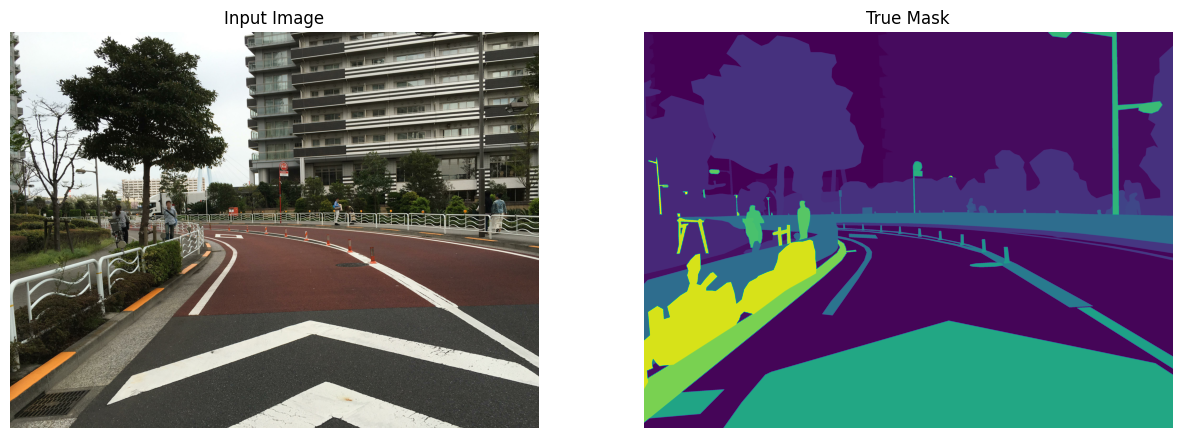

In [31]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


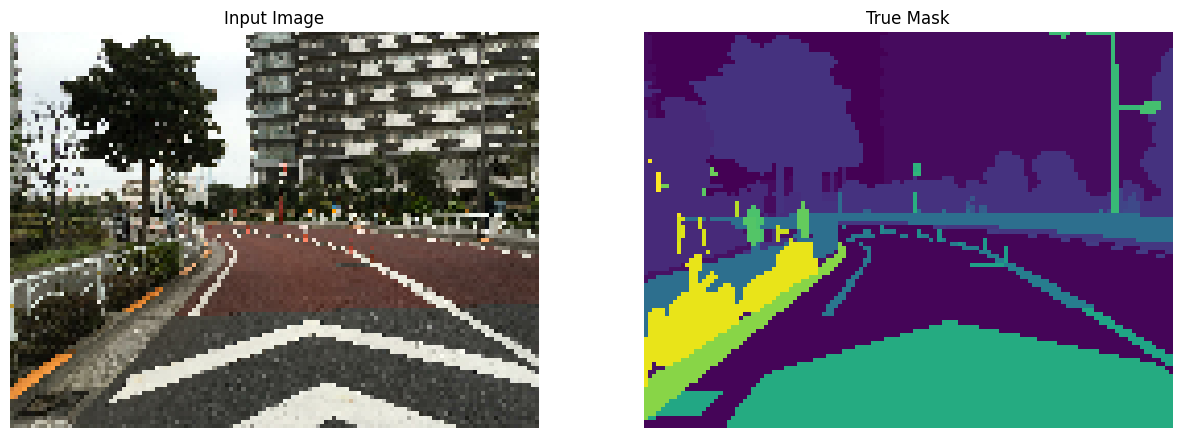

In [32]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [33]:
EPOCHS =150
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 4
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = model.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 114s 176ms/step - f1_score: 0.3216 - loss: 3.6576 - mean_iou: 0.0209 - pixel_accuracy: 0.3212 - precision: 0.3214 - recall: 0.3218
Epoch 2/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - f1_score: 0.3617 - loss: 3.0025 - mean_iou: 0.0230 - pixel_accuracy: 0.3614 - precision: 0.3614 - recall: 0.3621
Epoch 3/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 169ms/step - f1_score: 0.3679 - loss: 2.9478 - mean_iou: 0.0253 - pixel_accuracy: 0.3676 - precision: 0.3676 - recall: 0.3683
Epoch 4/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 78s 156ms/step - f1_score: 0.3743 - loss: 2.9171 - mean_iou: 0.0270 - pixel_accuracy: 0.3740 - precision: 0.3740 - recall: 0.3747
Epoch 5/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 152ms/step - f1_score: 0.3745 - loss: 2.9291 - mean_iou: 0.0250 - pixel_accuracy: 0.3741 - precision: 0.3741 - recall: 0.3748
Epoch 6/150
500/500 ━━━

In [34]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [36]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


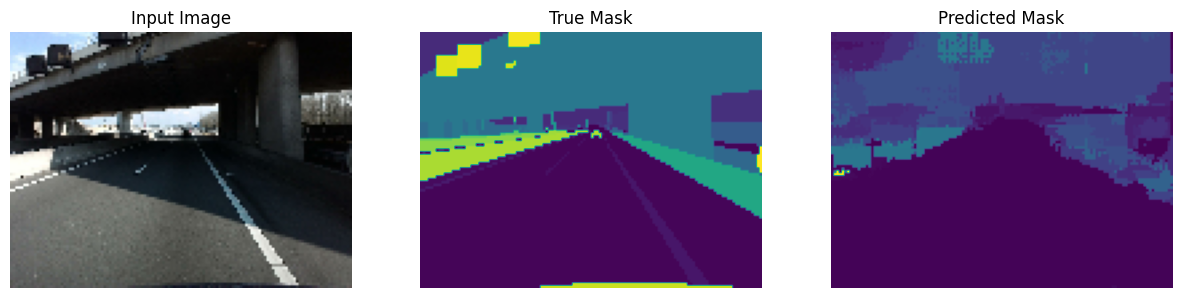

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


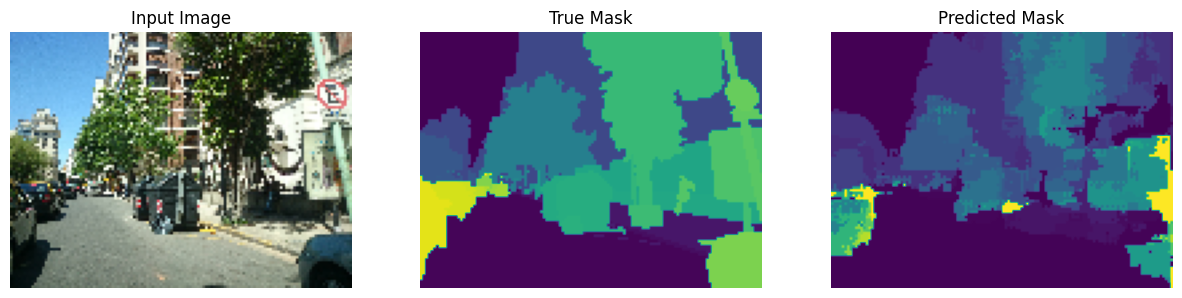

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


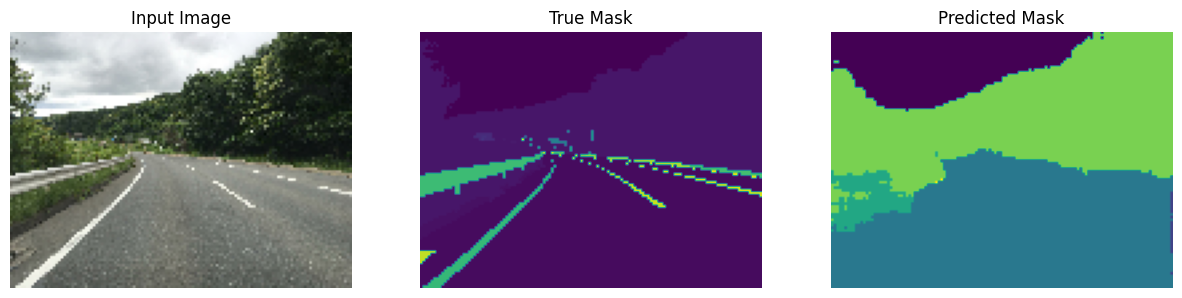

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


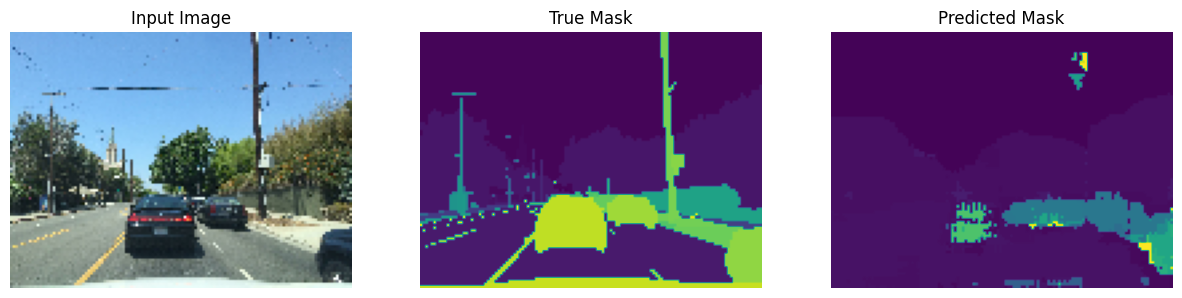

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


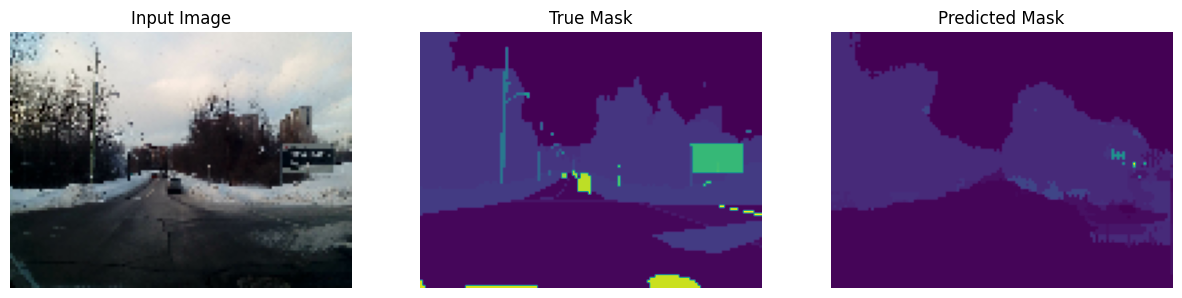

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


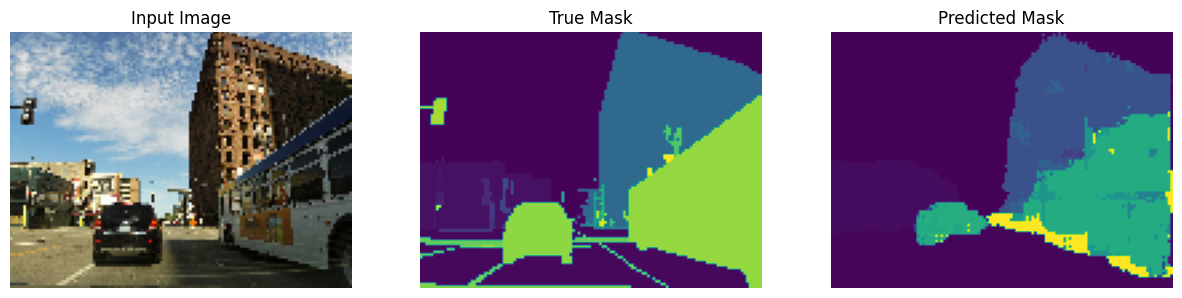

In [37]:
show_predictions(train_dataset, 6)

In [38]:
def preprocess_test(image):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    return input_image

In [1]:

# import os
# import cv2  # Assuming you're using OpenCV to load images
# import numpy as np
# import tensorflow as tf

# # Assuming test_masks_folder contains the ground truth masks
# test_masks_folder = "test_masks"

# # Load ground truth masks
# true_masks = []
# for image_path in test_image_list:
#     mask_path = os.path.join(test_masks_folder, os.path.basename(image_path))
#     true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     true_masks.append(true_mask)

# # Make predictions using the trained model
# pred_masks = []
# for test_image in test_image_ds.take(len(test_image_list)):
#     test_image = test_image[tf.newaxis, ...]
#     pred_mask = model.predict(test_image)
#     pred_masks.append(pred_mask)

# def create_rgb_mask(mask):
#     """
#     Converts a single-channel mask to a three-channel RGB mask
#     """
#     return cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

# def convert_mask_color(mask, color_scheme):
#     """
#     Converts a mask's color scheme according to the given color_scheme dictionary
#     """
#     converted_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)  # Create an empty RGB mask
#     for value in color_scheme:
#         converted_mask[mask == value] = color_scheme[value]
#     return converted_mask

# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors

# def show_test_predictions(test_images_preprocessed, pred_masks, true_masks, num=1):
#     """
#     Displays the first num images of the test set along with predicted and ground truth masks
#     """
#     cmap = plt.cm.viridis  # Use the 'viridis' colormap

#     for i, (test_image, pred_mask, true_mask) in enumerate(zip(test_images_preprocessed, pred_masks, true_masks)):
#         if i >= num:
#             break
        
#         display_list = [test_image, create_mask(pred_mask), true_mask]
#         title = ['Test Image', 'Predicted Mask', 'True Mask']
#         display(display_list, title, cmap)

# def display(display_list, title=None, cmap=None):
#     """
#     Displays a list of images with their corresponding titles
#     """
#     plt.figure(figsize=(15, 15))
#     for i in range(len(display_list)):
#         plt.subplot(1, len(display_list), i+1)
#         plt.title(title[i])
#         if cmap is not None and i == len(display_list) - 1:  # Apply colormap only to the last image
#             plt.imshow(display_list[i], cmap=cmap)
#         else:
#             plt.imshow(display_list[i])
#         plt.axis('off')
#     plt.show()

# # Display predictions for the test set along with ground truth
# show_test_predictions(test_image_ds, pred_masks, true_masks, num=17)

